In [19]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
import torchvision.transforms as T 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
import pandas as pd
import utils

TS = 48
MPATH = '__pycache__/duelingdqn_policy_net.pt'
DO_TRAIN = False

# samples = list(range(201, 211)) #[201, 202, 203]
samples = [221, 243, 232, 202, 204, 214, 205, 239, 248, 273, 282, 289]
data_train, df_date = utils.load_data('AusGrid_preprocess.csv', samples, TS)

State : [PV.gen, LD, PV.charge, PV.dischare, BS, GD, COST]
- PV.gen : PV generatoin power
- LD : Load consumption power
- PV.charge : Battery charging power
- PV.dischare : Battery discharging power
- BS : Battery status
- GD : Grid imort(+)/export(-) power
- COST : Cost for power

Action : [0, 1]
- 0 : discharging
- 1 : charging

Cost funciton(Reward)
- Self consumption : (PV - PV.charge + PV.dischare - GD) / PV
- Self sufficency : (PV - PV.charge + PV.dischare - GD) / LD

In [21]:
class Dueling_DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(Dueling_DQN, self).__init__()
        self.num_actions = n_actions
        
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2_adv = nn.Linear(256, 128)
        self.layer2_val = nn.Linear(256, 128)
        
        self.layer3_adv = nn.Linear(128, n_actions)
        self.layer3_val = nn.Linear(128, 1)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x_adv = F.relu(self.layer2_adv(x))
        x_val = F.relu(self.layer2_val(x))

        adv = self.layer3_adv(x_adv)
        val = self.layer3_val(x_val).expand(x_val.size(0), self.num_actions)

        # Q-value        
        x = val + adv - adv.mean(1).unsqueeze(1).expand(x_val.size(0), self.num_actions)
        return x

In [22]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TARGET_UPDATE = 10

n_observaons = 7
print(n_observaons)
n_actions = 2
policy_net = Dueling_DQN(n_observaons, n_actions).to(device)
target_net = Dueling_DQN(n_observaons, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

7


<All keys matched successfully>

In [23]:
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1

    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


In [24]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

In [25]:
optimizer = optim.AdamW(policy_net.parameters(), lr=1e-5, amsgrad=True)
memory = ReplayMemory(20000)

In [26]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return 0

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
        
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    # print(loss.item())

    optimizer.zero_grad()
    loss.backward()

    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)

    optimizer.step()

    return loss.item()

    

In [ ]:
def Action(x):
    if x.item() == 1:
        return "Charge"
    elif x.item() == 0:
        return "Discharge"
    else:
        return "None"

if DO_TRAIN == True:
    loss_list = []
    reward_list = []
    all_sc_ss = []

    loop = 10
    num_episodes = len(data_train)

    for l in range(loop):
        for i_episode in range(num_episodes):
            capacities = utils.cal_stds(data_train[i_episode%len(data_train)])
            for c in capacities:        
                epMemory = list()
                env = utils.ENV_BATT(data_train[i_episode%len(data_train)], max(0, c))
                state = env.reset()    
                state = torch.tensor(state).unsqueeze(0)

                loss_value = 0.0
                reward_value = 0.0

                total_export = 0.0
                total_import = 0.0
                total_pv = 0.0
                total_ld = 0.0
                    
                for i in range(env.data_env.shape[0]):
                    action = select_action(state)
                    observation, reward, done=env.step(action.item())
                    reward = torch.tensor([reward], device=device)
                    reward_value += reward.squeeze(0).numpy()

                    next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
                    memory.push(torch.as_tensor(state), action, next_state, reward)
                    state = next_state

                    loss_value += optimize_model()

                    total_export += state.squeeze(0).numpy()[5] if state.squeeze(0).numpy()[5] < 0 else 0
                    total_import += state.squeeze(0).numpy()[5] if state.squeeze(0).numpy()[5] > 0 else 0
                    total_pv += state.squeeze(0).numpy()[0]
                    total_ld += state.squeeze(0).numpy()[1]
                    
                    if (i + 1) % TS == 0:
                        loss_list.append(loss_value)
                        loss_value = 0.0
                        reward_list.append(reward_value)
                        reward_value = 0.0
                
                sc = (total_pv + total_export)/total_pv
                ss = (total_ld - total_import)/total_ld
                all_sc_ss.append([sc, ss])
                print(i_episode, 'sc and ss', sc, ss)

        target_net.load_state_dict(policy_net.state_dict())
        print(l, i_episode, 'Complete!!')

/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


0 sc and ss 0.4609387859925765 0.12952950554806097
0 sc and ss 0.5261769796811844 0.14786224569898462
0 sc and ss 0.6841938068431264 0.19225425648409392
0 sc and ss 0.809573889400677 0.22750028538168693
0 0 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


1 sc and ss 0.6826324887101759 0.20925138793606027
1 sc and ss 0.8049312794050131 0.24625767562341266
1 sc and ss 0.9423490960617468 0.2886164965420882
1 sc and ss 0.9678692047107449 0.29665340808960877
0 1 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


2 sc and ss 0.5315089206538207 0.09675092589714623
2 sc and ss 0.9016628770594196 0.16413029867083143
2 sc and ss 0.9689882075840178 0.17638557368382854
2 sc and ss 0.9521975796125655 0.17332916450435198
0 2 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


3 sc and ss 0.8304987208899236 0.4817559188412839
3 sc and ss 0.8711051009427683 0.5053108786629179
3 sc and ss 0.924782308116506 0.53644796725075
3 sc and ss 0.9352517715804396 0.5425210963353814
0 3 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


4 sc and ss 0.6091100843242274 0.2922594634214036
4 sc and ss 0.6091100843242274 0.2922594634214036
4 sc and ss 0.8020124568630478 0.3848166960952967
4 sc and ss 0.9524245869255723 0.4569865213811905
0 4 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


5 sc and ss 0.7978787142218957 0.4399461865449579
5 sc and ss 0.9334366268957015 0.5146921164114743
5 sc and ss 0.9628853561813873 0.5309299929661357
5 sc and ss 0.9724992564781721 0.5362310477950931
0 5 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


6 sc and ss 0.7013676130716349 0.5810085004646116
6 sc and ss 0.7465504184554327 0.6184376509526658
6 sc and ss 0.7869441816992458 0.6518995894939135
6 sc and ss 0.7955099064588971 0.6589953814150202
0 6 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


7 sc and ss 0.7707267157516717 0.6311482129635767
7 sc and ss 0.7976815767494049 0.6532215519176944
7 sc and ss 0.8376347929407664 0.6859392460579641
7 sc and ss 0.8342264485394306 0.6831481527162432
0 7 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


8 sc and ss 0.5342408549616824 0.45354942400674664
8 sc and ss 0.6869938878831477 0.5837579057730776
8 sc and ss 0.7429714834504343 0.6317803285700742
8 sc and ss 0.8485932997469041 0.7217009874863758
0 8 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


9 sc and ss 0.5169814526722469 0.6086446762903633
9 sc and ss 0.5986493699508442 0.7060009283368038
9 sc and ss 0.5932363290254642 0.6998110158431018
9 sc and ss 0.6234155730997967 0.7354119496764489
0 9 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


10 sc and ss 0.6246342600708185 0.7160460771831245
10 sc and ss 0.6838452312889799 0.7843439003315806
10 sc and ss 0.674745362262678 0.7733196289635876
10 sc and ss 0.6921555851301389 0.7937469878680133
0 10 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


11 sc and ss 0.3716199334999416 0.3836764959028839
11 sc and ss 0.5079308162930274 0.5246835275291852
11 sc and ss 0.7007318929508531 0.7254594479334372
11 sc and ss 0.7517176189268643 0.7785010814322826
0 11 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


0 sc and ss 0.4609387859925765 0.12952950554806097
0 sc and ss 0.8564870856047228 0.24068347459718648
0 sc and ss 0.7304206979962237 0.20525725903251635
0 sc and ss 0.8689614961773853 0.24418893828444882
1 0 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


1 sc and ss 0.6826324887101759 0.20925138793606027
1 sc and ss 0.962831529897364 0.2950795763733858
1 sc and ss 0.9678517450924654 0.2966214631142988
1 sc and ss 0.9686739887377899 0.29690461913659394
1 1 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


2 sc and ss 0.5315089206538207 0.09675092589714623
2 sc and ss 0.7728698597335669 0.1404106831001999
2 sc and ss 0.9423253304836606 0.17153211231734763
2 sc and ss 0.9324916180447844 0.16974207509391998
1 2 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


3 sc and ss 0.5220525542512647 0.30272604066311326
3 sc and ss 0.8404965085725001 0.4875554383767067
3 sc and ss 0.8531006316525539 0.4937071537101428
3 sc and ss 0.9222735396721706 0.5349926802744414
1 3 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


4 sc and ss 0.6091100843242274 0.2922594634214036
4 sc and ss 0.6091100843242274 0.2922594634214036
4 sc and ss 0.6658310245443418 0.31921240200247236
4 sc and ss 0.9703711547429812 0.46559753355382166
1 4 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


5 sc and ss 0.7040461581912587 0.38820740154616185
5 sc and ss 0.9024642212786345 0.4976140928849793
5 sc and ss 0.9603390636561169 0.5295259807481942
5 sc and ss 0.9772268393411101 0.5388378126678982
1 5 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


6 sc and ss 0.6223070716487319 0.5146153748990094
6 sc and ss 0.7059007802197536 0.5839027448744889
6 sc and ss 0.7574372435682589 0.6267898529398469
6 sc and ss 0.8042599418247874 0.6660002917867649
1 6 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


7 sc and ss 0.534937059128288 0.4368027842240232
7 sc and ss 0.6601690206144294 0.5403149893576682
7 sc and ss 0.767905723480987 0.6272323170837987
7 sc and ss 0.8554000630623819 0.7002808939059629
1 7 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


8 sc and ss 0.43999983165757406 0.37316604641254086
8 sc and ss 0.4689075508311248 0.39801192669940594
8 sc and ss 0.4556366527105299 0.3867079293626138
8 sc and ss 0.4784381336716957 0.4065477180427979
1 8 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


9 sc and ss 0.5254402648884933 0.6180867069962795
9 sc and ss 0.6058074292395624 0.7140449384948536
9 sc and ss 0.5938052886347706 0.6991651117982794
9 sc and ss 0.621409498235586 0.7319993830364921
1 9 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


10 sc and ss 0.3145480752942001 0.3587985790040971
10 sc and ss 0.5939487846875232 0.6793759677641446
10 sc and ss 0.6651044761501834 0.7606612020011831
10 sc and ss 0.7129086167807045 0.8156042674863914
1 10 Complete!!


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)
/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/1242845595.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


11 sc and ss 0.34343786108760027 0.3544936555791082
11 sc and ss 0.5615735240409517 0.5806110868947829
11 sc and ss 0.6138183704394424 0.6345773249209853
11 sc and ss 0.7103170848989807 0.7352257208286785
1 11 Complete!!


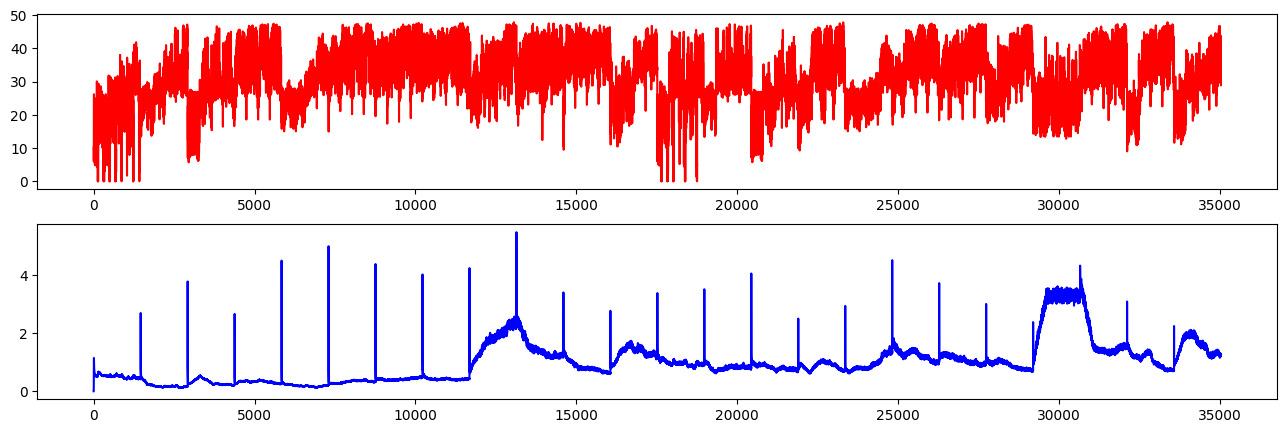

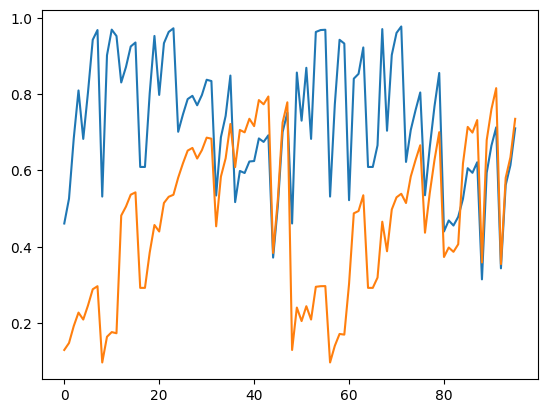

In [ ]:
if DO_TRAIN == True:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,5))
    axes[0].plot(np.array(reward_list), 'r')
    # plt.ylim(0, 0.4)
    axes[1].plot(np.array(loss_list), 'b')
    # plt.ylim(0, 0.4)
    plt.show() 

    plt.plot(np.array(all_sc_ss)[:, 0])
    plt.plot(np.array(all_sc_ss)[:, 1])
    plt.show()

In [92]:
data_test, df_date = utils.load_data('AusGrid_preprocess.csv', [93], TS)
data_test = data_test[0]
stds = utils.cal_stds(data_test)
print(stds)

(1, 4, 8, 15)


In [ ]:
capacity = stds[1]
env = utils.ENV_BATT(data_test, max(0, capacity))
state = env.reset()    
state = torch.tensor(state).unsqueeze(0)

policy_net.load_state_dict(torch.load(MPATH, weights_only=True))

df_out = pd.DataFrame(columns=['PV', 'LD', 'PV.C', 'PV.D', 'BT', 'GD', 'COST', 'AC', 'RD'])

with torch.no_grad():
    for i in range(env.data_env.shape[0]): 
        # action = select_action(state)
        action = policy_net(state).max(1).indices.view(1, 1)        
        observation, reward, done=env.step(action.item())
        reward = torch.tensor([reward], device=device)
        next_state = observation.clone().detach().unsqueeze(0)
        st = next_state.numpy().squeeze(0)
        at = action.item()
        # print('Current x : ', t, 'Action :', at, ', y : ', next_state, 'reward :', reward.item())

        st = np.concatenate((st, np.array([at-1, reward.item()])))
        df_out.loc[i] = st
        state = next_state


/var/folders/hv/t1mrtt815b713sd0fqxv51hm0000gn/T/ipykernel_1535/3192478879.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state).unsqueeze(0)


                      PV     LD     BT   AC     GD        RD
2012-07-01 00:30:00  0.0  0.131  0.400 -1.0  0.131  0.000000
2012-07-01 01:00:00  0.0  0.131  0.400 -1.0  0.131  0.000000
2012-07-01 01:30:00  0.0  0.131  0.400 -1.0  0.131  0.000000
2012-07-01 02:00:00  0.0  0.131  0.400 -1.0  0.131  0.000000
2012-07-01 02:30:00  0.0  0.144  0.400 -1.0  0.144  0.000000
...                  ...    ...    ...  ...    ...       ...
2012-07-05 22:30:00  0.0  0.850  1.849  0.0  0.850  0.576084
2012-07-05 23:00:00  0.0  0.531  1.849  0.0  0.531  0.575372
2012-07-05 23:30:00  0.0  0.225  1.849  0.0  0.225  0.575372
2012-07-06 00:00:00  0.0  0.163  1.849  0.0  0.163  0.575275
2012-07-06 00:30:00  0.0  0.144  1.849  0.0  0.144  0.575252

[241 rows x 6 columns]


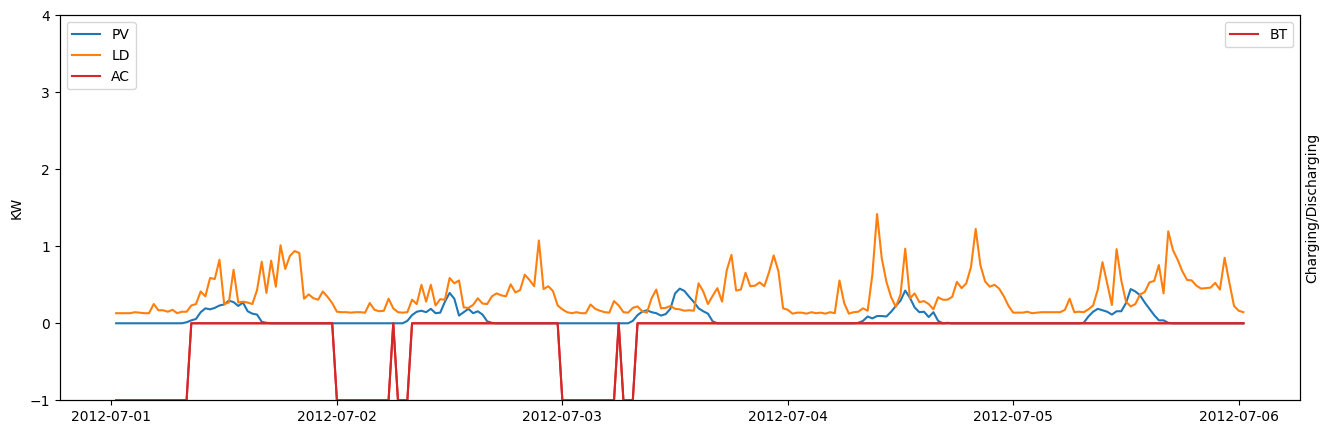

In [119]:
start_pos = 0
duration = TS*5
df_dis = df_out[['PV', 'LD', 'BT', 'AC', 'GD', 'RD']]
df_dis = df_dis.set_index(pd.Index(df_date.values))

pv =  df_dis['PV'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ld =  df_dis['LD'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
bt =  df_dis['BT'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values
ac =  df_dis['AC'].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].values

fig, ax1 = plt.subplots(figsize=(16, 5))
ax1.plot(df_date.values[start_pos:start_pos+duration+1], pv, label='PV', color='#1f77b4')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ld, label='LD', color='#ff7f0e')
ax1.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='AC', color='#d62728')
ax1.legend(loc='upper left')
ax1.set_ylabel('KW')
ax1.set_ylim(-1, 4)

ax2 = ax1.twinx()
ax2.plot(df_date.values[start_pos:start_pos+duration+1], ac, label='BT', color='#d62728')
ax2.legend(loc='upper right')
ax2.set_ylabel('Charging/Discharging')
ax2.set_yticks([])
ax2.set_ylim(-1, 4)

# ax = df_dis[['PV', 'LD', 'BT', 'AC']].loc[df_date.values[start_pos]:df_date.values[start_pos+duration]].plot(figsize=(16,5))
# ax.set_ylim(-1, 3)
# ax.set_ylabel('KW')
print(df_dis.loc[df_date.values[start_pos]:df_date.values[start_pos+duration]])
plt.show()

Text(0, 0.5, 'KW')

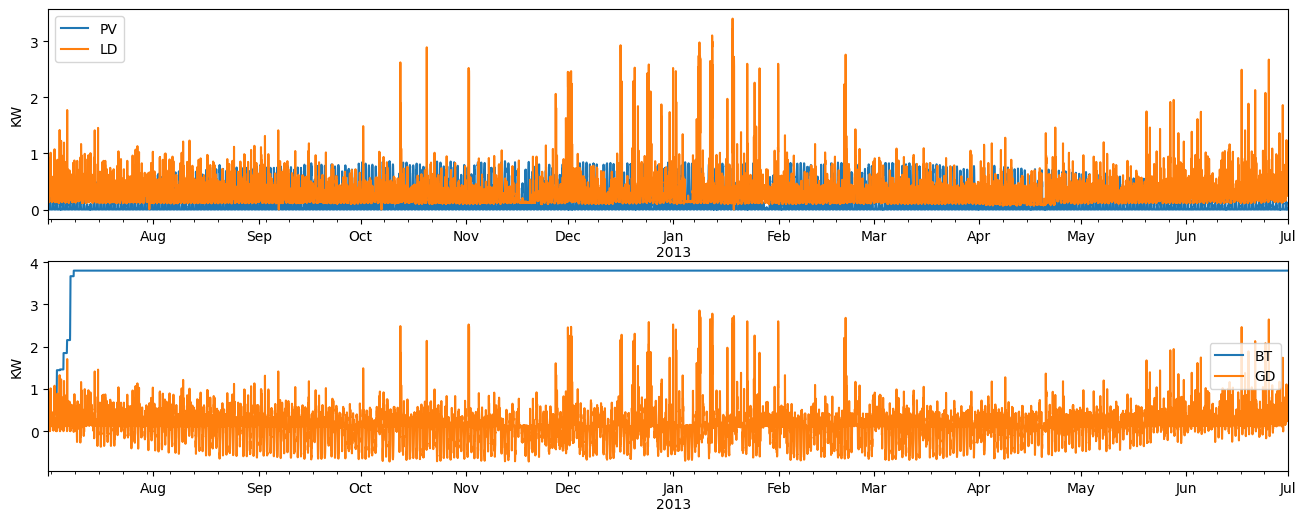

In [120]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16,6))
df_dis[['PV', 'LD']].plot(ax=axes[0])
df_dis[['BT', 'GD']].plot(ax=axes[1])

axes[0].set_ylabel('KW')
axes[1].set_ylabel('KW')

In [121]:
Egen = df_out['PV'].sum()
print(Egen, 'KW')
Eload = df_out['LD'].sum()
print(Eload, 'KW')
GDimport = df_out[df_out['GD'] > 0]['GD'].sum()
print(GDimport)
GDexport = df_out[df_out['GD'] < 0]['GD'].sum()
print(GDexport)

SC = (Egen + GDexport)/Egen
SS = (Eload - GDimport)/Eload
print('SC :', SC)
print('SS :', SS)

2574.432000159286 KW
4791.973995695822 KW
3437.4029981996864
-1216.461000951007
SC : 0.5274837319937983
SS : 0.28267494746691424


In [122]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
 
max_len = len(df_out)

pv =  df_out['PV'].iloc[:].values
ld =  df_out['LD'].iloc[:].values
bt =  df_out['BT'].iloc[:].values
ac =  df_out['AC'].iloc[:].values
gd =  df_out['GD'].iloc[:].values
# ct =  df_out['COST'].iloc[:].values

def interactive_plot(window, start):    
    window *= 48
    start *= 48
    fig, ax1 = plt.subplots(figsize=(16, 5))    
    ax1.plot(df_date.values, pv, label='PV', color='#1f77b4')
    ax1.plot(df_date.values, ld, label='LD', color='#ff7f0e')
    ax1.plot(df_date.values, ac, label='AC', color='#d62728')
    ax1.plot(df_date.values, gd, label='GD', color='black')
    # ax1.plot(df_date.values, ct, label='COST', color='grey')
    ax1.legend(loc='upper left')
    ax1.set_ylabel('KW')

    ax2 = ax1.twinx()
    ax2.plot(df_date.values, bt, label='BT', color='#2ca02c')
    ax2.legend(loc='upper right')
    ax2.set_ylabel('KW')
    
    start = min(start, max_len-window)
    ax1.set_xlim(df_date.values[start], df_date.values[start+window-1])
    
    plt.show()

 
 
interact(interactive_plot, window=(1, 10, 1), start=(0, 365, 1))

interactive(children=(IntSlider(value=5, description='window', max=10, min=1), IntSlider(value=182, descriptio…

<function __main__.interactive_plot(window, start)>